# 成都二手房长啥样 —— 链家数据

下面的分析的源数据是从链家网上抓取的成都二手房数据，截至时间2019年1月16日。目的也简单，一个想买房的人关注一下所在城市的房价情况。

需要注意的问题：
- 只含普通住房， 不含公寓、别墅
- 链家网上只有成都一、二圈层的二手房信息（缺乏三圈层的数据），共52548条
- 不同区域下面有重复的商圈，抓取数据时注意去重和商圈的正确归属
- 商圈直接划分错误，比如`犀浦`归到了`新都`
- 一些较远的区县归属到了相邻的区域内，比如`新津`在`双流`内，因为较远区县的房子很少，单独拿出来意义不大，暂且默认这种方式

In [71]:
import pymongo
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

In [2]:
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False
pd.set_option('display.max_columns', 50)
sns.set_context('talk')
warnings.filterwarnings('ignore')

In [3]:
client = pymongo.MongoClient('localhost')
db = client.spider

data = pd.DataFrame(list(db.lianjia.find()))
del data['_id']
data = data[['title', 'link', 'building', 'layout', 'size', 'orientation', 'decoration', 'elevator', 'zone', 'location',
            'floor', 'num_of_floor', 'year', 'type', 'follow', 'watch', 'how_long_since_release', 'tags', 'unit', 'total']]

# 1、数据清洗

先看看数据的基本信息，部分变量有缺失值，稍后进行处理。

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52548 entries, 0 to 52547
Data columns (total 20 columns):
title                     52548 non-null object
link                      52548 non-null object
building                  52548 non-null object
layout                    52548 non-null object
size                      52548 non-null float64
orientation               52548 non-null object
decoration                52548 non-null object
elevator                  44464 non-null object
zone                      52548 non-null object
location                  52548 non-null object
floor                     52322 non-null object
num_of_floor              52548 non-null int64
year                      43395 non-null object
type                      49879 non-null object
follow                    52548 non-null int64
watch                     52548 non-null int64
how_long_since_release    52548 non-null object
tags                      52548 non-null object
unit                      525

## 1.1 区域

从网上抓取数据时，区域的归属明显有问题，比如`犀浦`归到了`新都`，下面进行调整。

In [6]:
#names = ['锦江', '青羊', '武侯', '高新', '成华', '金牛', '天府新区', '高新西',  '双流', '温江', '郫都', '龙泉驿', '新都', '天府新区南区', '青白江', '都江堰']
#for name in names:
#    print("***", name, '***')
#    print(data[data['zone'] == name]['location'].value_counts())
#    print('='*50)
data.loc[data['zone'] == '天府新区南区', ['zone']] = '天府新区'
data.loc[data['location'] == '犀浦', ['zone']] = '郫都'

In [7]:
data['bedroom_num'] = data['layout'].apply(lambda x: int(x.split('室')[0]))
data['parlour_num'] = data['layout'].apply(lambda x: int(x.split('室')[1].replace('厅', '')))

## 1.2 房屋朝向

In [8]:
directions = []
for i in data['orientation']:
    directions.extend(i)
directions = pd.unique(directions)

zero_matrix = np.zeros((len(data), len(directions)))
dummy = pd.DataFrame(zero_matrix, columns=sorted(directions))
for i, j in enumerate(data['orientation']):
    indices = dummy.columns.get_indexer(j)
    dummy.iloc[i, indices] = 1
data = pd.concat([data, dummy.add_prefix('direct_')], axis=1)

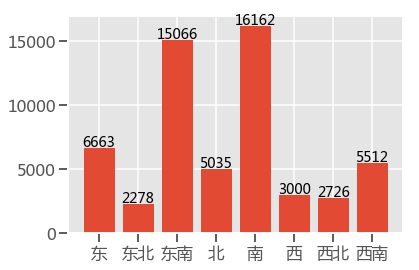

In [9]:
plt.bar(dummy.apply(np.sum, axis=0).index, dummy.apply(np.sum, axis=0).values)
for i, j in zip(range(8), dummy.apply(np.sum, axis=0).values):
    plt.text(i, j+100, int(j), ha='center', fontsize=14)

## 1.3 楼层情况

In [10]:
data.loc[(data['elevator'].isna()) & (data['num_of_floor']>7), 'elevator'] = '有电梯'
data['elevator'].fillna('无电梯', inplace=True)

data['floor'].fillna('未知', inplace=True)

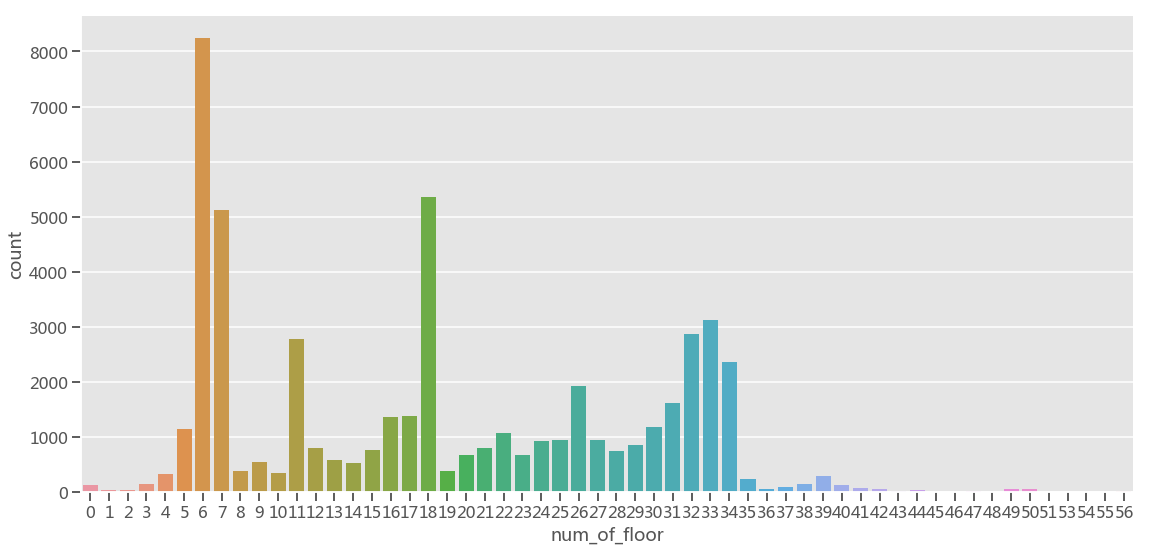

In [11]:
sns.catplot(x='num_of_floor', data=data, kind='count',height=8, aspect=2)

## 1.4 楼龄和类型

In [12]:
data.loc[data['year'] == '2020', ['year']] = '2016'
data.sort_values('building', inplace=True)
group = data.groupby('building')['year'].apply(lambda x: x.fillna(x.mode().iloc[0] if len(x.mode())>0 else np.nan))
data['year'] = group.values
data.sort_values(['location', 'num_of_floor'], inplace=True)
group = data.groupby(['location', 'num_of_floor'])['year'].apply(lambda x: x.fillna(x.mode().iloc[0] if len(x.mode())>0 else np.nan))
data['year'] = group.values
group = data.groupby(['location'])['year'].apply(lambda x: x.fillna(x.mode().iloc[0] if len(x.mode())>0 else np.nan))
data['year'] = group.values
data['year'].fillna('2018', inplace=True)

In [13]:
data.sort_values('building', inplace=True)
group = data.groupby('building')['type'].apply(lambda x: x.fillna(x.mode().iloc[0] if len(x.mode())>0 else np.nan))
data['type'] = group.values
data.sort_values(['location', 'num_of_floor'], inplace=True)
group = data.groupby(['location', 'num_of_floor'])['type'].apply(lambda x: x.fillna(x.mode().iloc[0] if len(x.mode())>0 else np.nan))
data['type'] = group.values
data['type'].fillna('其它', inplace=True)

In [14]:
data.sort_index(inplace=True)
data['year'] = data['year'].astype(np.int16)
data['building_age'] = 2019 - data['year']

## 1.5 发布时长

In [15]:
data.loc[data['how_long_since_release'] == '刚刚', 'how_long_since_release'] = '0天'
data.loc[data['how_long_since_release'].str.contains('天'), 'how_long_since_release'] = '0个月'
data.loc[data['how_long_since_release'].str.contains('年'), 'how_long_since_release'] = '12个月'
data.rename({'how_long_since_release': 'since_release'}, axis=1, inplace=True)
data['since_release'] = data['since_release'].str.replace('个月', '')
data['since_release'] = data['since_release'].astype(np.int8)

## 1.6 其它

In [16]:
data['tag_地铁'] = data['tags'].apply(lambda x: 1 if '近地铁' in x else 0)
data['tag_满两年'] = data['tags'].apply(lambda x: 1 if '房本满两年' in x else 0)
data['tag_满五年'] = data['tags'].apply(lambda x: 1 if '房本满五年' in x else 0)
data.loc[data['tag_满五年'] == 1, 'tag_满两年'] = 1

In [17]:
data.drop(['title', 'link', 'orientation', 'tags', 'year'], axis=1, inplace=True)

In [18]:
data.head()

,building,layout,size,decoration,elevator,zone,location,floor,num_of_floor,type,follow,watch,since_release,unit,total,bedroom_num,parlour_num,direct_东,direct_东北,direct_东南,direct_北,direct_南,direct_西,direct_西北,direct_西南,building_age,tag_地铁,tag_满两年,tag_满五年
0,德馨苑,4室2厅,152.00,毛坯,有电梯,锦江,川师,高,32,塔楼,49,29,7,23027,350.0,4,2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,8,1,0,0
1,德馨苑,3室1厅,139.40,精装,有电梯,锦江,川师,低,32,塔楼,1,1,0,25467,355.0,3,1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,8,1,1,1
2,华润幸福里二期,3室2厅,89.11,其他,有电梯,锦江,川师,高,32,板塔结合,153,18,9,21322,190.0,3,2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,1,0,0
3,比华利国际城三期,3室1厅,92.54,其他,有电梯,锦江,川师,中,33,板楼,75,16,4,22153,205.0,3,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,5,1,1,0
4,万科城市花园,3室2厅,139.16,精装,有电梯,锦江,川师,低,11,板塔结合,90,4,12,26445,368.0,3,2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,12,1,1,1


# 2、分析内容

## 2.1 成都的二手房价几何

### 2.1.1 整体分布

从链家网获取的数据，截至到2019年1月16日，成都一二圈层在售普通住宅（不含公寓、别墅）52548套；成都二手房价基本呈现正态分布，均价15614元，整体房价在4万元以内，超过4万的有261套，占总体的0.5%。

Text(0.5,1,'成都二手房房价分布')

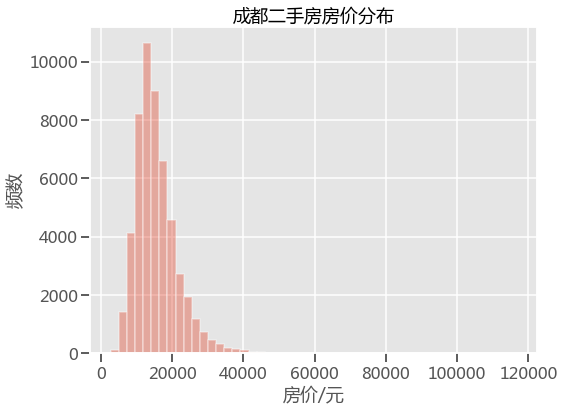

In [20]:
fig, ax = plt.subplots(figsize=(8,6))
sns.distplot(data['unit'], bins=50, kde=False, ax=ax, hist_kws={'edgecolor': 'white'})
ax.set_xlabel('房价/元')
ax.set_ylabel('频数')
ax.set_title('成都二手房房价分布')

In [21]:
data['unit'].describe()

count     52548.000000
mean      15614.560516
std        6012.502724
min        2696.000000
25%       11646.000000
50%       14533.000000
75%       18374.250000
max      116646.000000
Name: unit, dtype: float64

### 2.1.2 最高和最低

最低房价不到3000元，最高的超过的10万元，我很好奇这两个极端分别长什么样。

- 房价低于3000的有一套，在龙泉的阳光城，1室1厅，虽然是毛坯房，这个价格确实便宜。
- 房价高于10万的有两套房，分别在青羊的浣花溪和龙泉的阳光城，从面积和楼层来看，二者都是独栋的小楼，而且都是精装修，富豪专享。

In [22]:
data[data['unit'] < 3000]

,building,layout,size,decoration,elevator,zone,location,floor,num_of_floor,type,follow,watch,since_release,unit,total,bedroom_num,parlour_num,direct_东,direct_东北,direct_东南,direct_北,direct_南,direct_西,direct_西北,direct_西南,building_age,tag_地铁,tag_满两年,tag_满五年
50217,五角大楼,1室1厅,77.92,毛坯,无电梯,龙泉驿,阳光城,中,6,板楼,8,10,0,2696,21.0,1,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,13,0,0,0


In [23]:
data[data['unit'] > 100000]

,building,layout,size,decoration,elevator,zone,location,floor,num_of_floor,type,follow,watch,since_release,unit,total,bedroom_num,parlour_num,direct_东,direct_东北,direct_东南,direct_北,direct_南,direct_西,direct_西北,direct_西南,building_age,tag_地铁,tag_满两年,tag_满五年
5869,金林半岛,5室2厅,347.96,精装,无电梯,青羊,浣花溪,低,1,板楼,43,2,6,100587,3500.0,5,2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,13,0,0,0
50345,中粮御嶺湾,4室3厅,428.65,精装,无电梯,龙泉驿,阳光城,低,3,其它,0,0,1,116646,5000.0,4,3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,5,0,0,0


### 2.1.3 区域差异

高新和锦江站在第一梯队，均价超过2万，后面紧跟青羊1.9万，传统5城区的均价都在1.5万以上；虽然青白江和都江堰排在后面，但考虑到二者和中心区域的距离，8000多的均价真不算低了。

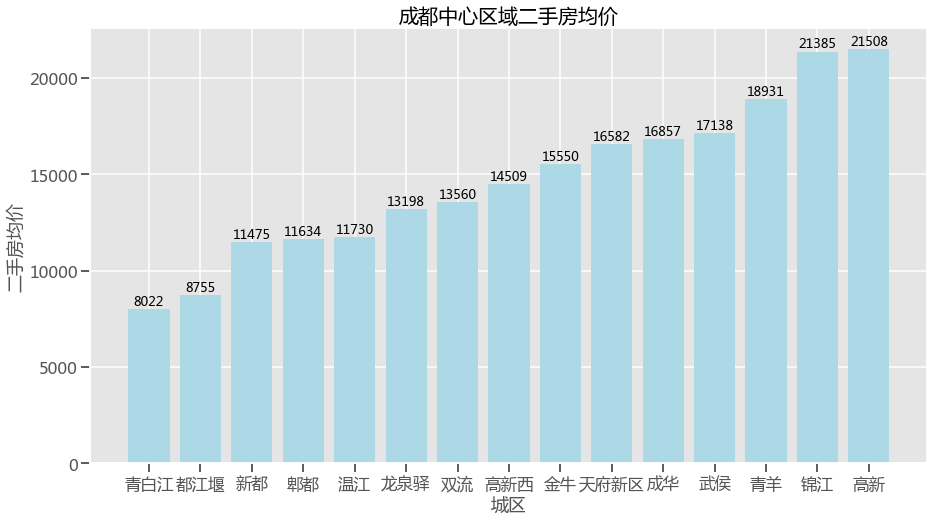

In [24]:
g = data.groupby('zone')['unit'].mean().sort_values()
x = g.index.values
y = g.values
fig, ax = plt.subplots(figsize=(15,8))
ax.bar(x, y, color='lightblue')
ax.set_xlabel('城区')
ax.set_ylabel('二手房均价')
ax.set_title('成都中心区域二手房均价', fontsize=20)
for i, j in zip(range(15), y):
    ax.text(i, j+200, int(j), ha='center', fontsize=13)

房价前十的商圈中锦江占据了一半，不愧是中心城区，剩下的是高新、天府新区和青羊，这很好的把成都高房价的两个中心给标注出来了：传统中心区域和如火如荼的成都南区

In [25]:
data.groupby(['zone','location'])['unit'].mean().sort_values(ascending=False)[:10].reset_index()

,zone,location,unit
0,锦江,东大路,32681.310000
1,高新,金融城,32516.338174
2,天府新区,麓湖生态城,32306.931034
3,青羊,浣花溪,28778.696970
4,高新,大源,26640.843137
5,锦江,卓锦城,25100.317365
6,锦江,东湖,24892.242063
7,高新,天府长城,24628.547771
8,锦江,攀成钢,24361.131356
9,锦江,盐市口,24228.486772


## 2.2 市面上的房子是多大的

### 2.2.1 多少平米和几个卧室

市面上的二手房以二居和三居为主，占成都市场的77%，毕竟这是最符合一般家庭需求的布局。市面上的平均面积98平米（大家都住大房子啊），整体面积分布集中在50-150平米。

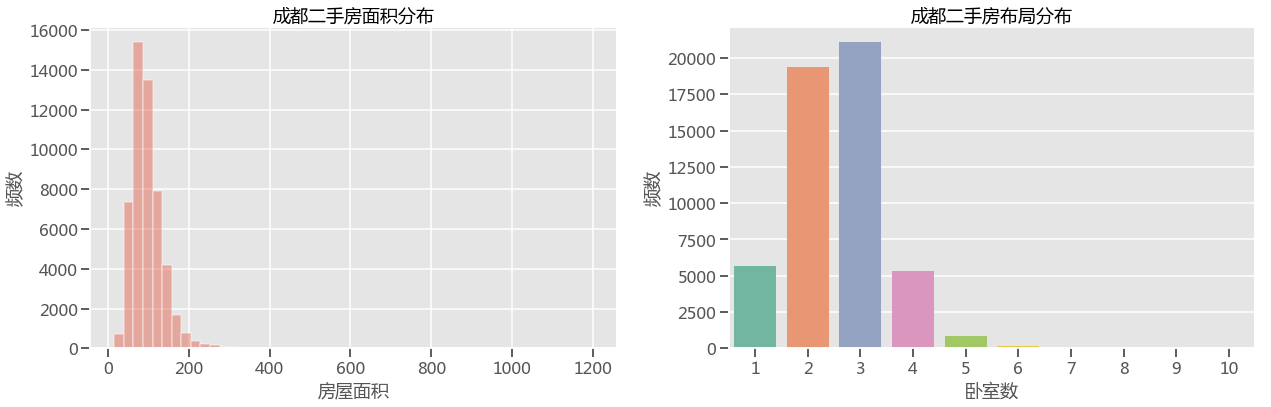

In [27]:
fig, ax = plt.subplots(1,2,figsize=(18,6))
sns.distplot(data['size'], bins=50, kde=False, ax=ax[0], hist_kws={'edgecolor': 'white'})
ax[0].set_xlabel('房屋面积')
ax[0].set_ylabel('频数')
ax[0].set_title('成都二手房面积分布')
    
sns.countplot(x='bedroom_num', data=data, ax=ax[1], palette='Set2')
ax[1].set_xlabel('卧室数')
ax[1].set_ylabel('频数')
ax[1].set_title('成都二手房布局分布')
fig.tight_layout()

### 2.2.2 原来还有这么大的房子

住房面积的差异还是很大的，最大面积居然达到了1200平米，果然是贫穷限制了我的想象力。
+ “此房为实地看过，四面可以看湖，带大露台，户型挑高大气。适合一家人居住。属于麒麟会非常好的位置”

In [28]:
data['size'].describe()

count    52548.000000
mean        98.268351
std         41.669932
min         15.900000
25%         73.930000
50%         88.950000
75%        118.622500
max       1200.000000
Name: size, dtype: float64

In [29]:
data[data['size'] > 1000]

,building,layout,size,decoration,elevator,zone,location,floor,num_of_floor,type,follow,watch,since_release,unit,total,bedroom_num,parlour_num,direct_东,direct_东北,direct_东南,direct_北,direct_南,direct_西,direct_西北,direct_西南,building_age,tag_地铁,tag_满两年,tag_满五年
35623,麓湖麒麟荟,4室3厅,1200.0,其他,有电梯,天府新区,麓湖生态城,高,28,板楼,6,0,4,33334,4000.0,4,3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4,0,0,0


传统5城区的面积相对比较小，平均面积都在90平米左右（中心区域寸土寸金）；要住大房子，就要往周边走，特别是天府新区，财大气粗，平均面积超过了120，扎心了。

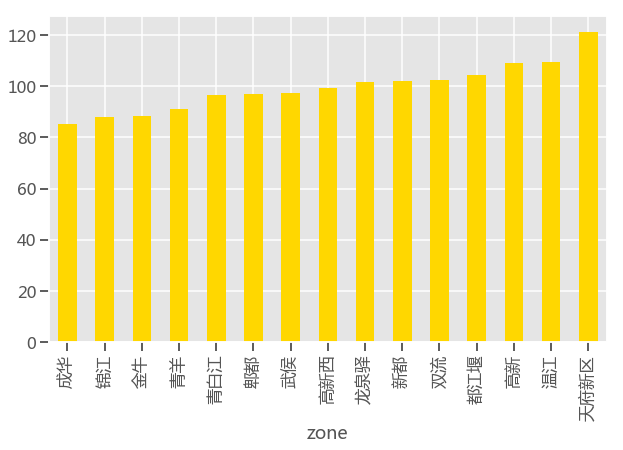

In [30]:
data.groupby('zone')['size'].mean().sort_values().plot.bar(figsize=(10,6), color='gold')

## 2.3 楼盘的年龄和“性别”

### 2.3.1 二手房真的是老房子？

有一部分房子真是老房子了，20年以上的有5%，15年以上19%；更多的还是近10来年的准新房，楼龄10年内的达到60%，5年内的22%。从这个角度来看，市面上的大部分二手房都不算老，属于准新房，人们买房不是为了住，更多的是把房子当作商品来交易。

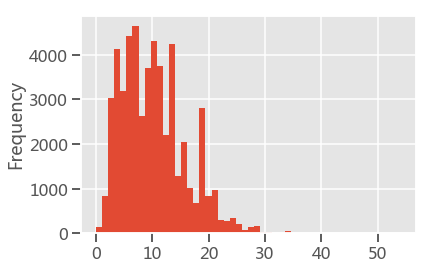

In [32]:
data['building_age'].plot.hist(bins=50)

well，和想象的不太一样，价格并没有随楼龄变大而明显减少，二者相关性不强。

In [33]:
data[['building_age','unit']].corr()

,building_age,unit
building_age,1.000000,-0.178739
unit,-0.178739,1.000000


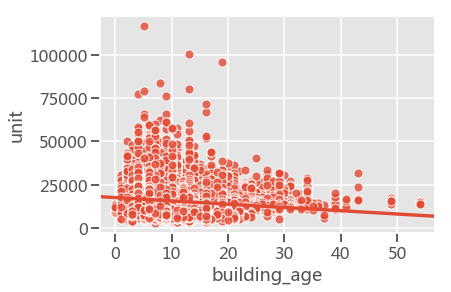

In [34]:
sns.regplot(x='building_age', y='unit', data=data, scatter_kws={'edgecolor': 'white'})

### 2.3.2 “性别”

之前并不懂塔楼、板楼、板塔结合这些类型到底是什么意思，在网上查了一下，发现还是很重要的，直接影响楼层结构和布局。更多信息看这里：http://baijiahao.baidu.com/s?id=1602783742441450499
- 板楼：一般建筑层数不会超过12层，一般的板楼中同层的住户在2到4户。其平面图特点是长度明显大于宽度。
- 塔楼：一般是指高层建筑，其平面图特点是若干户（一般多于四五户）共同围绕或者环绕一组公共竖向交通形成的楼房平面，平面的长度和宽度大致相同，外观像塔一样。一般塔楼的同层住户在6户以上，简单来说就是建筑显＂细长＂。
- 蝶状楼：也称板塔结合建筑结构，可以说是结合了塔楼和板楼的特点，从平面图上看，像张开翅膀的蝴蝶，公摊面积比板楼少，采光、通风性能又优于塔楼。

塔楼和板塔结合的房子的分布非常相似，楼龄集中在10年以内，说明现在的新楼（高楼）大多采用这两种结构。老房子多采用板楼形式，本次样本中，30年以上的房子，有超过90%都是板楼；楼层较低的新房子也会采用板楼。

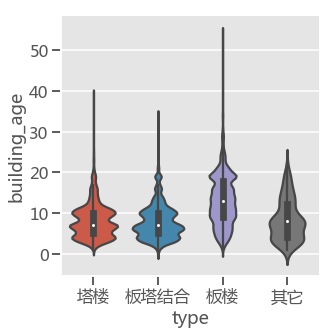

In [35]:
sns.catplot(x='type', y='building_age', data=data, kind='violin')

## 2.4 地铁房更贵？

现在市面上有近2万套近地铁的二手房，抛开极大的离群值，地铁房平均比其它房贵12%。

In [37]:
data.groupby('tag_地铁')['unit'].describe().round(2)

,count,mean,std,min,25%,50%,75%,max
tag_地铁,,,,,,,,
0,32674.0,14956.93,6274.53,2696.0,10907.25,13719.0,17507.75,116646.0
1,19874.0,16695.74,5383.19,5678.0,12942.00,15790.0,19498.25,71735.0


## 2.5 这些房子在网上挂了多久了？

In [38]:
#1.时长分布
#2.时间比较长的是什么样的房子

发布的时间越长，在售的房子越少；有点异常的是，近2000套发布超过了一年的房子还没买出去。

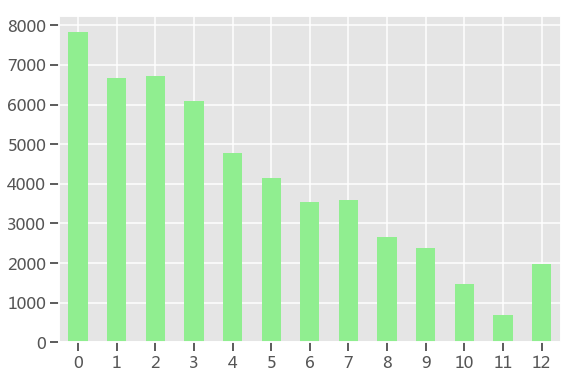

In [39]:
data['since_release'].value_counts().sort_index().plot.bar(figsize=(9,6), color='lightgreen', rot=0)

In [40]:
data['in_six'] = 1
data.loc[data['since_release']>6, 'in_six'] = 0

## 2.6 哪些因素影响了房价

对我们每个人来说，心中或许都有个疑问：影响房价的因素有哪些，是什么造就了如今的房价？

虽然这个样本中有20多个变量，但与影响房价的众多内、外原因比起来，还相差甚远，如果用这些变量来建立模型预测房价，是不恰当的。这里只看个概况，哪些变量比较突出，或许能管中窥豹吧。

客观因素中，地段无疑是最重要的，房子所在的地区、商圈和楼盘都会直接影响价格。除此之外， 建筑的楼层、楼龄和类型等方面也有影响。

In [65]:
dt = data.copy()
objects = dt.select_dtypes(include='object').columns.values
dt.drop('total', axis=1, inplace=True)
for obj in objects:
    dt[obj] = LabelEncoder().fit_transform(dt[obj])

x = list(dt.columns.values)
x.remove('unit')
y = 'unit'
rf = RandomForestRegressor(n_estimators=500, max_depth=10, oob_score=True, n_jobs=6)
rf.fit(dt[x], dt[y])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=6,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

In [89]:
rmse = mean_squared_error(dt[y], rf.oob_prediction_)**.5
print('实际房价和预测房价相差{}元'.format(rmse.round(2)))

实际房价和预测房价相差3054.54元


In [88]:
importance = pd.DataFrame({'features': x, 'importance': rf.feature_importances_})
importance.sort_values('importance', ascending=False, inplace=True)
importance.reset_index(drop=True, inplace=True)
importance

,features,importance
0,zone,0.339687
1,location,0.270024
2,num_of_floor,0.094442
3,size,0.069733
4,building_age,0.066686
5,elevator,0.053335
6,building,0.038858
7,layout,0.028616
8,type,0.010229
9,tag_地铁,0.006882


# 3、可以注意的点

- 成都主要城区在售普通住宅（不含公寓、别墅）52548套，均价15614元，房价区间集中在5000-25000元，高新和锦江的均价2万多，有点伤不起
- 市面上的二手房以二居和三居为主，占成都市场的77%，面积集中在50-150平米；要住大房子，就向天府新区看齐
- 在售的二手房大部分都是准新房，炒房这条路走到哪里了呢
- 高层楼盘基本都是塔楼或板塔结合
- 客观方面，地段影响价格和价值

要买房的时候再来跑一次。